# Bitcoin Forecasting using Public Sentiment(Tweets), News Sentiment and Historical Data

# Importing required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import datetime as dt

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Dataset Uploading

In [2]:
df_prices = pd.read_csv('BTC-USD -Final.csv')
df_tweet_sentiments = pd.read_csv('tweets_weighted_sentiments_final_updated.csv')
df_news_sentiments = pd.read_csv('News_Weighted_Sentiments Updated.csv')

In [3]:
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402
1,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653
2,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143
3,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687
4,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886


In [4]:
df_tweet_sentiments.head()

,polarity,subjectivity,Compound
0,-0.000060,0.001379,0.000000
1,0.000067,0.001711,0.000000
2,-0.000116,0.001086,-0.000388
3,-0.000055,0.001177,0.000000
4,0.000048,0.001585,0.000000


In [5]:
df_news_sentiments.head()

,TextBlob Polarity,TextBlob Subjectivity,VADER Compound Score
0,0.000604,0.001382,-0.002119
1,0.000000,0.000000,0.000000
2,0.000000,0.000829,0.000000
3,0.000000,0.000251,0.001076
4,0.000000,0.000865,0.000000


# Dataset Modification

Modifying dataset to predict closed price using yesterday's data.

In [6]:
# Convert 'Date' column to datetime
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
# Create new columns
df_prices['High Yesterday'] = df_prices['High'].shift(1)
df_prices['Low Yesterday'] = df_prices['Low'].shift(1)
df_prices['Open Yesterday'] = df_prices['Open'].shift(1)
df_prices['Close Yesterday'] = df_prices['Close'].shift(1)
df_prices['Volume Yesterday'] = df_prices['Volume'].shift(1)
df_prices['Open Today'] = df_prices['Open']
df_prices['Close_Today'] = df_prices['Close']

# Drop the first row (as we don't have data for yesterday)
df_prices = df_prices.iloc[1:]
# Reset index
df_prices.reset_index(drop=True, inplace=True)

In [7]:
df_prices = df_prices.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

Merging news sentiment and tweet sentiment dataset with historical dataset.

In [8]:
# Join the DataFrames column-wise
maindf = pd.concat([df_prices, df_tweet_sentiments, df_news_sentiments], axis=1)

In [9]:
maindf = maindf.rename(columns={'polarity':'Tweets Polarity', 'subjectivity':'Tweet Subjectivity', 'Compound': 'Tweet Compound',
                                'TextBlob Polarity': 'News Polarity', 'TextBlob Subjectivity':'News Subjectivity','VADER Compound Score':'News Compound'})

In [10]:
maindf.head()

,Date,High Yesterday,Low Yesterday,Open Yesterday,Close Yesterday,Volume Yesterday,Open Today,Close_Today,Tweets Polarity,Tweet Subjectivity,Tweet Compound,News Polarity,News Subjectivity,News Compound
0,2021-02-06,38225.906250,36658.761719,36931.546875,38144.308594,5.859807e+10,38138.386719,39266.011719,-0.000060,0.001379,0.000000,0.000604,0.001382,-0.002119
1,2021-02-07,40846.546875,38138.386719,38138.386719,39266.011719,7.132603e+10,39250.191406,38903.441406,0.000067,0.001711,0.000000,0.000000,0.000000,0.000000
2,2021-02-08,39621.835938,37446.152344,39250.191406,38903.441406,6.550064e+10,38886.828125,46196.464844,-0.000116,0.001086,-0.000388,0.000000,0.000829,0.000000
3,2021-02-09,46203.929688,38076.324219,38886.828125,46196.464844,1.014672e+11,46184.992188,46481.105469,-0.000055,0.001177,0.000000,0.000000,0.000251,0.001076
4,2021-02-10,48003.722656,45166.960938,46184.992188,46481.105469,9.180985e+10,46469.761719,44918.183594,0.000048,0.001585,0.000000,0.000000,0.000865,0.000000


# Checking for Null Values

In [11]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 0


In [12]:
print('NA values:',maindf.isnull().values.any())

NA values: False


# EDA(Exploratory Data Analysis)

In [13]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                511 non-null    datetime64[ns]
 1   High Yesterday      511 non-null    float64       
 2   Low Yesterday       511 non-null    float64       
 3   Open Yesterday      511 non-null    float64       
 4   Close Yesterday     511 non-null    float64       
 5   Volume Yesterday    511 non-null    float64       
 6   Open Today          511 non-null    float64       
 7   Close_Today         511 non-null    float64       
 8   Tweets Polarity     511 non-null    float64       
 9   Tweet Subjectivity  511 non-null    float64       
 10  Tweet Compound      511 non-null    float64       
 11  News Polarity       511 non-null    float64       
 12  News Subjectivity   511 non-null    float64       
 13  News Compound       511 non-null    float64       

In [14]:
maindf.describe()

,Date,High Yesterday,Low Yesterday,Open Yesterday,Close Yesterday,Volume Yesterday,Open Today,Close_Today,Tweets Polarity,Tweet Subjectivity,Tweet Compound,News Polarity,News Subjectivity,News Compound
count,511,511.000000,511.000000,511.000000,511.000000,5.110000e+02,511.000000,511.000000,5.110000e+02,511.000000,5.110000e+02,511.000000,511.000000,5.110000e+02
mean,2021-10-19 00:00:00.000000256,45722.403162,43266.750348,44596.249117,44555.304432,3.931484e+10,44562.763645,44518.367168,7.388441e-07,0.001423,-7.550154e-07,0.000015,0.000984,4.690892e-07
min,2021-02-06 00:00:00,20141.160156,17708.623047,19010.902344,19017.642578,1.373656e+10,19010.902344,19017.642578,-1.330204e-04,0.001008,-5.171966e-04,-0.002571,0.000000,-3.447441e-03
25%,2021-06-13 12:00:00,39021.906250,36408.632813,37730.638672,37732.664062,2.709411e+10,37730.638672,37712.330078,0.000000e+00,0.001294,0.000000e+00,0.000000,0.000636,0.000000e+00
50%,2021-10-19 00:00:00,45077.578125,42848.687500,43946.742188,43960.933594,3.425096e+10,43946.742188,43960.933594,0.000000e+00,0.001413,0.000000e+00,0.000000,0.000963,0.000000e+00
75%,2022-02-23 12:00:00,52777.353515,49899.457032,51679.496094,51691.978515,4.629868e+10,51679.496094,51691.978515,0.000000e+00,0.001536,0.000000e+00,0.000000,0.001311,1.031304e-03
max,2022-07-01 00:00:00,68789.625000,66382.062500,67549.734375,67566.828125,3.509679e+11,67549.734375,67566.828125,1.916943e-04,0.002312,5.708644e-04,0.002133,0.002513,1.637980e-03
std,NaN,10533.287094,10160.852530,10329.955604,10374.804114,2.187100e+10,10382.450293,10431.121081,5.342473e-05,0.000178,1.685887e-04,0.000493,0.000599,1.260278e-03


In [15]:
sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]

print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2021-02-06 00:00:00
Ending Date 2022-07-01 00:00:00


In [16]:
maindf.columns

Index(['Date', 'High Yesterday', 'Low Yesterday', 'Open Yesterday',
       'Close Yesterday', 'Volume Yesterday', 'Open Today', 'Close_Today',
       'Tweets Polarity', 'Tweet Subjectivity', 'Tweet Compound',
       'News Polarity', 'News Subjectivity', 'News Compound'],
      dtype='object')

In [17]:
names = cycle(['Open Yesterday', 'Close Yesterday','High Yesterday','Low Yesterday'])

fig = px.line(maindf, x=maindf.Date, y=[maindf['Open Yesterday'], maindf['Close Yesterday'],
                                          maindf['High Yesterday'], maindf['Low Yesterday']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

Analysis of year 2021

In [18]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-02-06')
                     & (maindf['Date'] < '2021-12-31')]

In [19]:
monthvise= maindf.groupby(y_2021['Date'].dt.strftime('%B'))[['Open Yesterday','Close Yesterday']].mean()
new_order = ['February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open Yesterday,Close Yesterday
Date,,
February,47768.320143,48174.216542
March,54133.831023,54553.458291
April,57429.976693,57245.675261
May,47683.572707,47101.909904
June,35912.220508,35921.555339
July,34031.376386,34232.542843
August,45360.376764,45530.297127
September,46224.295052,46052.297917
October,56689.930444,57346.549143


In [20]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open Yesterday'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close Yesterday'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price for year 2021')
fig.show()

Analysis of year 2022

In [21]:
maindf['Date'].max()

Timestamp('2022-07-01 00:00:00')

In [22]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2022 = maindf.loc[(maindf['Date'] >= '2022-01-01')
                     & (maindf['Date'] < '2022-07-01')]

In [23]:
monthvise= maindf.groupby(y_2022['Date'].dt.strftime('%B'))[['Open Yesterday','Close Yesterday']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open Yesterday,Close Yesterday
Date,,
January,41666.431200,41366.787551
February,40598.756836,40595.255859
March,41587.337198,41890.578125
April,41976.529948,41696.113021
May,32122.710938,31897.155683
June,25170.523568,24783.938281


In [24]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open Yesterday'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close Yesterday'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price for year 2021')
fig.show()

Overall Analysis of Dataset

In [25]:
# Lets First Take all the Close Price
closedf = maindf[['Date','Close_Today']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (511, 2)


In [26]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close_Today,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='green')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2021-2022', plot_bgcolor='black',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Model Building

# 1.) LSTM

Preparing dataset to train the model.

In [40]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
# Creating training and target variables
X = maindf[['High Yesterday', 'Low Yesterday', 'Open Yesterday',
       'Close Yesterday', 'Volume Yesterday', 'Open Today',
        'Tweets Polarity', 'Tweet Subjectivity', 'Tweet Compound',
       'News Polarity', 'News Subjectivity', 'News Compound']].values
y = maindf['Close_Today'].values


In [42]:
# scaling and normalization
scaler2 = MinMaxScaler()
maindf["y_scaled"] = scaler2.fit_transform(maindf[["Close_Today"]])
y = maindf['y_scaled'].values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [43]:
# Split data into train and test sets (assuming time-series data)
train_size = int(len(X_scaled) * 0.8)
test_size = len(X_scaled) - train_size
X_train, X_test = X_scaled[0:train_size,:], X_scaled[train_size:len(X_scaled),:]

#closing
y_train, y_test = y[0:train_size], y[train_size:len(y)]
dummy = maindf[["Close_Today"]].values[train_size:len(y)]

In [44]:
# Function to create dataset with look back
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
        # print(a)
    return np.array(dataX), np.array(dataY)

In [45]:
X_train, y_train = create_dataset(X_train)
X_test, y_test = create_dataset(X_test)

In [46]:
# Define the LSTM model
model = Sequential()
initializer = GlorotUniform()

# Add Batch Normalization after each LSTM layer for better convergence
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(units=100, kernel_regularizer=L2(0.01), kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=16))
model.add(BatchNormalization())
model.add(Dense(units=1, kernel_initializer=initializer))

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning:

The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



In [47]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping])
from sklearn.metrics import mean_absolute_error
# Predict on the test data
y_pred = model.predict(X_test)
# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

Epoch 1/100
7/7 - 6s - loss: 2.7695 - val_loss: 2.0446 - 6s/epoch - 909ms/step
Epoch 2/100
7/7 - 0s - loss: 2.1417 - val_loss: 1.9178 - 119ms/epoch - 17ms/step
Epoch 3/100
7/7 - 0s - loss: 1.9231 - val_loss: 1.7708 - 130ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 1.7195 - val_loss: 1.6254 - 125ms/epoch - 18ms/step
Epoch 5/100
7/7 - 0s - loss: 1.5792 - val_loss: 1.4900 - 127ms/epoch - 18ms/step
Epoch 6/100
7/7 - 0s - loss: 1.4469 - val_loss: 1.3669 - 116ms/epoch - 17ms/step
Epoch 7/100
7/7 - 0s - loss: 1.3108 - val_loss: 1.2553 - 125ms/epoch - 18ms/step
Epoch 8/100
7/7 - 0s - loss: 1.1959 - val_loss: 1.1514 - 124ms/epoch - 18ms/step
Epoch 9/100
7/7 - 0s - loss: 1.0788 - val_loss: 1.0579 - 123ms/epoch - 18ms/step
Epoch 10/100
7/7 - 0s - loss: 1.0087 - val_loss: 0.9751 - 126ms/epoch - 18ms/step
Epoch 11/100
7/7 - 0s - loss: 0.9156 - val_loss: 0.9017 - 135ms/epoch - 19ms/step
Epoch 12/100
7/7 - 0s - loss: 0.8408 - val_loss: 0.8353 - 126ms/epoch - 18ms/step
Epoch 13/100
7/7 - 0s - los

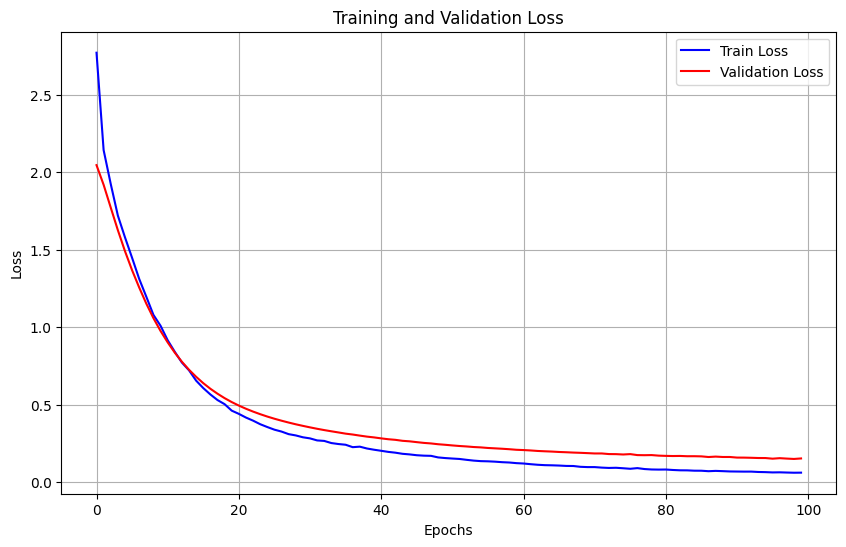

In [54]:
import matplotlib.pyplot as plt

# Get training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
mae = mae/10000
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
print("------------------------------------------------------------------")
print("Mean Absolute Error for LSTM: ", mae)
print("------------------------------------------------------------------")

------------------------------------------------------------------
Mean Absolute Error for LSTM:  312.7492504826077
------------------------------------------------------------------


4/4 [==============================] - 0s 8ms/step


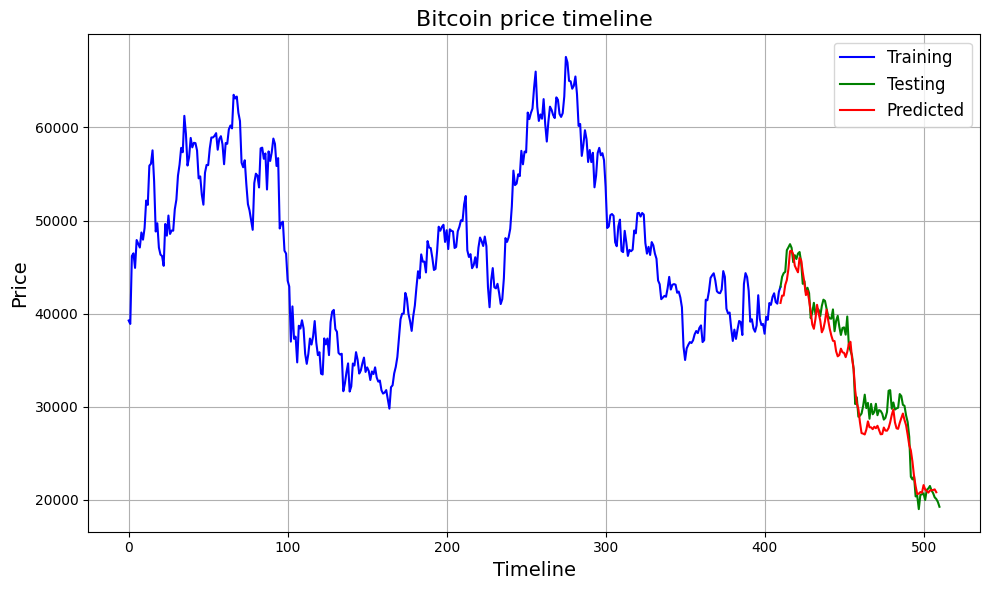

In [296]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

a = scaler2.inverse_transform(test_predict)

# Create a landscape plot
plt.figure(figsize=(10, 6))

# Plot the shifted 'a'
plt.plot(maindf["Close_Today"][:411], color='blue', label='Training')
plt.plot(maindf["Close_Today"][410:], color='green', label='Testing')

plt.plot(range(410, 509),a, color='red', label='Predicted')

# Decorations
plt.title('Bitcoin price timeline', fontsize=16)  # Add title with fontsize
plt.xlabel('Timeline', fontsize=14)      # Add X-axis label with fontsize
plt.ylabel('Price', fontsize=14)      # Add Y-axis label with fontsize
plt.legend(fontsize=12)                      # Add legend with fontsize
plt.grid(True)                               # Add gridlines
plt.tight_layout()                           # Adjust layout to prevent clipping of labels

# Save or Show the plot
plt.savefig('landscape_plot.png')  # Save the plot as an image
plt.show()

              # Show the plot
